In [1]:
import detectron2
import torch
import copy
import pickle 
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper
from detectron2.data import build_detection_train_loader
from detectron2.data import detection_utils as utils 
from detectron2.data.detection_utils import annotations_to_instances

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#for the mapepr
import copy
import logging
import numpy as np
from typing import List, Optional, Union
import torch

from detectron2.config import configurable

from detectron2.data import detection_utils as utils 
import detectron2.data.transforms as T

In [3]:
torch.__version__

'1.10.0'

# Register the dataset so that it can be used by dataloader

In [4]:
def get_detectron_train_data():
    data = [] #here is where we will collect the coco dicts
    root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Data/DetectronData/"
    xml_files = [
        "327_A1d_ASAP.xml",
        "281_A1f_ASAP.xml"
    ]
    for id in xml_files: #collect all of the individual WSI data 
        sample_id = id.split(".")[0]
        sample_data = None
        filepath = str(root + sample_id+".pickle")
        with open(filepath, 'rb') as handle:
            sample_data = pickle.load(handle)
        sample_data 
        for patch_info in sample_data:
            data.append(patch_info)
    return data


In [5]:
def get_detectron_test_data():
    data = [] #here is where we will collect the coco dicts
    root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Data/DetectronData/"
    xml_files = [
        "270_A1d_ASAP.xml"
    ]
    for id in xml_files: #collect all of the individual WSI data 
        sample_id = id.split(".")[0]
        sample_data = None
        filepath = str(root + sample_id+".pickle")
        with open(filepath, 'rb') as handle:
            sample_data = pickle.load(handle)
        sample_data 
        for patch_info in sample_data:
            data.append(patch_info)
    return data


In [6]:
train_data = get_detectron_train_data()
test_data = get_detectron_test_data()

In [9]:
print(len(train_data), len(test_data))

209 105


In [11]:
DatasetCatalog.register("nuclei_detection_train", get_detectron_train_data)
DatasetCatalog.register("nuclei_detection_test", get_detectron_test_data)

# later, to access the data:
data = DatasetCatalog.get("nuclei_detection_train")
data = DatasetCatalog.get("nuclei_detection_test")

In [12]:
MetadataCatalog.get("nuclei_detection_train").thing_classes = ["inflamm", "scc"] #0,1
MetadataCatalog.get("nuclei_detection_test").thing_classes = ["inflamm", "scc"] #0,1

In [13]:
# def mapper(dataset_dict):
#     dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
#     # can use other ways to read image
#     image = utils.read_image(dataset_dict["file_name"], format="BGR")
#     # See "Data Augmentation" tutorial for details usage
#     auginput = T.AugInput(image)
#     transform = T.Resize((128, 128))(auginput)
#     image = torch.from_numpy(auginput.image.transpose(2, 0, 1))
#     annos = [
#         utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
#         for annotation in dataset_dict.pop("annotations")
#     ]
#     return {
#        # create the format that the model expects
#        "image": image,
#        "instances": utils.annotations_to_instances(annos, image.shape[1:])
#     }

In [14]:
# import pysnooper
# class NewMapper(DatasetMapper):
    
#     def _transform_annotations(self, dataset_dict, transforms, image_shape):
#     # USER: Modify this if you want to keep them for some reason.
#         for anno in dataset_dict["annotations"]:
#             if not self.use_instance_mask:
#                 anno.pop("segmentation", None)
#             if not self.use_keypoint:
#                 anno.pop("keypoints", None)

#         # USER: Implement additional transformations if you have other types of data
#         self.annos=annos = [
#             utils.transform_instance_annotations(
#                 obj, transforms, image_shape, keypoint_hflip_indices=self.keypoint_hflip_indices
#             )
#             for obj in dataset_dict.pop("annotations")
#             if obj.get("iscrowd", 0) == 0
#         ]
# #         print(self.instance_mask_format)
#         instances = utils.annotations_to_instances(
#             annos, image_shape, mask_format=self.instance_mask_format
#         )

#         # After transforms such as cropping are applied, the bounding box may no longer
#         # tightly bound the object. As an example, imagine a triangle object
#         # [(0,0), (2,0), (0,2)] cropped by a box [(1,0),(2,2)] (XYXY format). The tight
#         # bounding box of the cropped triangle should be [(1,0),(2,1)], which is not equal to
#         # the intersection of original bounding box and the cropping box.
#         if self.recompute_boxes:
#             instances.gt_boxes = instances.gt_masks.get_bounding_boxes()
#         dataset_dict["instances"] = utils.filter_empty_instances(instances)
        
# #     @pysnooper.snoop()
#     def __call__(self, dataset_dict):
#         """
#         Args:
#             dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.

#         Returns:
#             dict: a format that builtin models in detectron2 accept
#         """
#         dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
#         # USER: Write your own image loading if it's not from a file
#         image = utils.read_image(dataset_dict["file_name"], format=self.image_format)
#         utils.check_image_size(dataset_dict, image)

#         # USER: Remove if you don't do semantic/panoptic segmentation.
#         if "sem_seg_file_name" in dataset_dict:
#             sem_seg_gt = utils.read_image(dataset_dict.pop("sem_seg_file_name"), "L").squeeze(2)
#         else:
#             sem_seg_gt = None

#         aug_input = T.AugInput(image, sem_seg=sem_seg_gt)
#         transforms = self.augmentations(aug_input)
#         image, sem_seg_gt = aug_input.image, aug_input.sem_seg

#         image_shape = image.shape[:2]  # h, w
#         # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
#         # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
#         # Therefore it's important to use torch.Tensor.
#         dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))
#         if sem_seg_gt is not None:
#             dataset_dict["sem_seg"] = torch.as_tensor(sem_seg_gt.astype("long"))

#         # USER: Remove if you don't use pre-computed proposals.
#         # Most users would not need this feature.
#         if self.proposal_topk is not None:
#             utils.transform_proposals(
#                 dataset_dict, image_shape, transforms, proposal_topk=self.proposal_topk
#             )
# #         print(dataset_dict)
#         if not self.is_train:
#             # USER: Modify this if you want to keep them for some reason.
#             dataset_dict.pop("annotations", None)
#             dataset_dict.pop("sem_seg_file_name", None)
#             return dataset_dict
        
#         if "annotations" in dataset_dict.keys():
# #             print(dataset_dict)
#             self._transform_annotations(dataset_dict, transforms, image_shape)

#         return dataset_dict


In [15]:
mapper = DatasetMapper(is_train=True,
                         augmentations=[T.Resize((128, 128))], 
                         use_instance_mask = True, 
                         instance_mask_format = "polygon",
                         image_format="BGR")

In [16]:
mapper(train_data[0])

{'file_name': '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Data/Images/327_A1d_ASAP_0.jpg',
 'height': 128,
 'width': 128,
 'image_id': '327_A1d_ASAP_0',
 'image': tensor([[[223, 217, 224,  ..., 185, 178, 159],
          [213, 219, 226,  ..., 188, 168, 150],
          [207, 224, 225,  ..., 185, 147, 132],
          ...,
          [222, 221, 219,  ..., 202, 217, 203],
          [213, 211, 210,  ..., 191, 202, 185],
          [221, 214, 208,  ..., 172, 188, 184]],
 
         [[189, 184, 189,  ..., 135, 124, 103],
          [179, 186, 191,  ..., 138, 114,  94],
          [173, 188, 188,  ..., 137,  95,  78],
          ...,
          [195, 194, 192,  ..., 156, 171, 157],
          [186, 184, 183,  ..., 145, 156, 139],
          [194, 187, 181,  ..., 126, 142, 138]],
 
         [[226, 219, 223,  ..., 165, 153, 132],
          [216, 221, 225,  ..., 168, 144, 123],
          [210, 224, 222,  ..., 166, 125, 107],
  

In [17]:
train_dataloader = build_detection_train_loader(
    train_data,
    mapper=DatasetMapper(is_train=True,
                         augmentations=[T.Resize((128, 128))], 
                         use_instance_mask = True, 
                         instance_mask_format = "polygon",
                         image_format="BGR"), 
    total_batch_size = 1, 
    )

In [18]:
data = None
for x in train_dataloader:
    print(x[0]["instances"])
    data = x
    break

Instances(num_instances=1, image_height=128, image_width=128, fields=[gt_boxes: Boxes(tensor([[  7.0898, 108.0742,  20.5273, 124.5840]])), gt_classes: tensor([1]), gt_masks: PolygonMasks(num_instances=1)])


# Visualize Training Data

In [19]:
from detectron2.utils.visualizer import ColorMode, Visualizer
data

[{'file_name': '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Data/Images/327_A1d_ASAP_2.jpg',
  'height': 128,
  'width': 128,
  'image_id': '327_A1d_ASAP_2',
  'image': tensor([[[158, 193, 188,  ..., 135, 137, 126],
           [165, 202, 190,  ..., 127, 137, 136],
           [173, 212, 188,  ..., 131, 153, 167],
           ...,
           [155, 174, 186,  ..., 196, 212, 214],
           [159, 180, 190,  ..., 219, 204, 203],
           [191, 189, 187,  ..., 221, 201, 214]],
  
          [[110, 146, 141,  ...,  67,  67,  56],
           [117, 155, 143,  ...,  61,  69,  68],
           [125, 163, 141,  ...,  68,  89, 103],
           ...,
           [102, 122, 137,  ..., 158, 174, 176],
           [106, 128, 138,  ..., 181, 166, 165],
           [138, 135, 135,  ..., 183, 163, 176]],
  
          [[182, 214, 204,  ..., 108, 107,  96],
           [189, 223, 205,  ..., 102, 110, 109],
           [197, 231, 203,  

In [20]:
data[0]

{'file_name': '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Data/Images/327_A1d_ASAP_2.jpg',
 'height': 128,
 'width': 128,
 'image_id': '327_A1d_ASAP_2',
 'image': tensor([[[158, 193, 188,  ..., 135, 137, 126],
          [165, 202, 190,  ..., 127, 137, 136],
          [173, 212, 188,  ..., 131, 153, 167],
          ...,
          [155, 174, 186,  ..., 196, 212, 214],
          [159, 180, 190,  ..., 219, 204, 203],
          [191, 189, 187,  ..., 221, 201, 214]],
 
         [[110, 146, 141,  ...,  67,  67,  56],
          [117, 155, 143,  ...,  61,  69,  68],
          [125, 163, 141,  ...,  68,  89, 103],
          ...,
          [102, 122, 137,  ..., 158, 174, 176],
          [106, 128, 138,  ..., 181, 166, 165],
          [138, 135, 135,  ..., 183, 163, 176]],
 
         [[182, 214, 204,  ..., 108, 107,  96],
          [189, 223, 205,  ..., 102, 110, 109],
          [197, 231, 203,  ..., 110, 131, 145],
  

In [21]:
data[0]["image"].shape

torch.Size([3, 128, 128])

In [22]:
img = cv2.imread(data[0]["file_name"])
# plt.imshow(img)
# plt.show()

In [23]:
v = Visualizer(img)

In [24]:
# v = v.draw_dataset_dict(data[0])
v = v.overlay_instances(boxes=data[0]["instances"].gt_boxes, labels=data[0]["instances"].gt_classes.numpy(), masks=data[0]["instances"].gt_masks)

In [25]:
v

In [26]:
#  v = v.draw_instance_predictions(data[0]["instances"])

In [27]:
dir(v)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_setup_figure',
 'ax',
 'canvas',
 'dpi',
 'fig',
 'get_image',
 'height',
 'img',
 'reset_image',
 'save',
 'scale',
 'width']

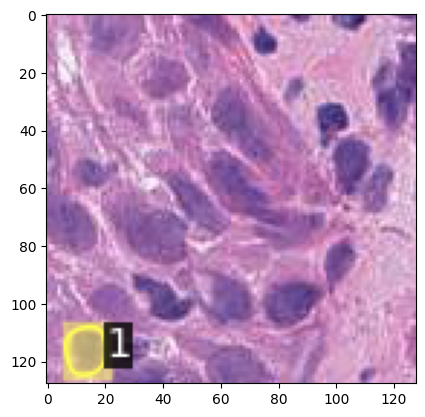

In [28]:
plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

# Training the Segmentation Model

In [29]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg

In [33]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("nuclei_detection_train")
cfg.DATASETS.TEST = ("nuclei_detection_test")
cfg.MODEL.DEVICE = "cuda:3"
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 5
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [34]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[01/13 00:32:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[01/13 00:32:21 d2.data.build]: Removed 0 images with no usable annotations. 209 images left.
[01/13 00:32:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/13 00:32:21 d2.data.build]: Using training sampler TrainingSampler
[01/13 00:32:21 d2.data.common]: Serializing 209 elements to byte tensors and concatenating them all ...
[01/13 00:32:27 d2.data.common]: Serialized dataset takes 65.57 MiB
WARNING [01/13 00:32:27 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

In [35]:
trainer.train()

[01/13 00:32:30 d2.engine.train_loop]: Starting training from iteration 0
[01/13 00:32:43 d2.utils.events]:  eta: 0:09:30  iter: 19  total_loss: 2.741  loss_cls: 1.231  loss_box_reg: 0.4164  loss_mask: 0.6966  loss_rpn_cls: 0.3304  loss_rpn_loc: 0.04657  time: 0.5958  data_time: 0.1648  lr: 4.9953e-06  max_mem: 4690M
[01/13 00:32:54 d2.utils.events]:  eta: 0:09:13  iter: 39  total_loss: 2.405  loss_cls: 1.071  loss_box_reg: 0.4603  loss_mask: 0.6919  loss_rpn_cls: 0.1883  loss_rpn_loc: 0.04734  time: 0.5857  data_time: 0.1531  lr: 9.9902e-06  max_mem: 4690M
[01/13 00:33:07 d2.utils.events]:  eta: 0:09:04  iter: 59  total_loss: 2.093  loss_cls: 0.8397  loss_box_reg: 0.4233  loss_mask: 0.6818  loss_rpn_cls: 0.09142  loss_rpn_loc: 0.04101  time: 0.5966  data_time: 0.1966  lr: 1.4985e-05  max_mem: 4690M
[01/13 00:33:18 d2.utils.events]:  eta: 0:08:50  iter: 79  total_loss: 2.001  loss_cls: 0.6868  loss_box_reg: 0.5279  loss_mask: 0.6687  loss_rpn_cls: 0.07807  loss_rpn_loc: 0.04472  time: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/scratch/ipykernel_227860/4032920361.py", line 1, in <module>
    trainer.train()
  File "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/engine/defaults.py", line 484, in train
    super().train(self.start_iter, self.max_iter)
  File "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/engine/defaults.py", line 494, in 

TypeError: object of type 'NoneType' has no len()